# 1. Importing Libraries

In [56]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from keras import Model
from tensorflow.keras.models import load_model
from keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# 2. Reading Dataset

In [57]:
df = pd.read_csv('FPT.csv')
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0


# 3. Dataset Overview

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Date/Time      97406 non-null  object 
 2   Open           97406 non-null  float64
 3   High           97406 non-null  float64
 4   Low            97406 non-null  float64
 5   Close          97406 non-null  float64
 6   Volume         97406 non-null  int64  
 7   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.9+ MB


**Date/Time is stored as object, have to be converted to datetime**

# 4. Preparing Data

## 4.1. Selecting feature
I aim to predict Close

In [59]:
df = df[['Date/Time', 'Close']]

## 4.2. Converting Data

In [60]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.sort_values(by='Date/Time', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
print(df['Date/Time'].min(), df['Date/Time'].max())
df.head()

2018-12-25 09:15:00 2020-12-22 14:46:00


,Date/Time,Close
0,2018-12-25 09:15:00,30.89
1,2018-12-25 09:16:00,30.81
2,2018-12-25 09:17:00,30.74
3,2018-12-25 09:18:00,30.74
4,2018-12-25 09:19:00,30.74


## 4.3. Checking For Missing Value

In [61]:
df.isna().sum()

Date/Time    0
Close        0
dtype: int64

No missing value

# 5. Visualize Stock Price History

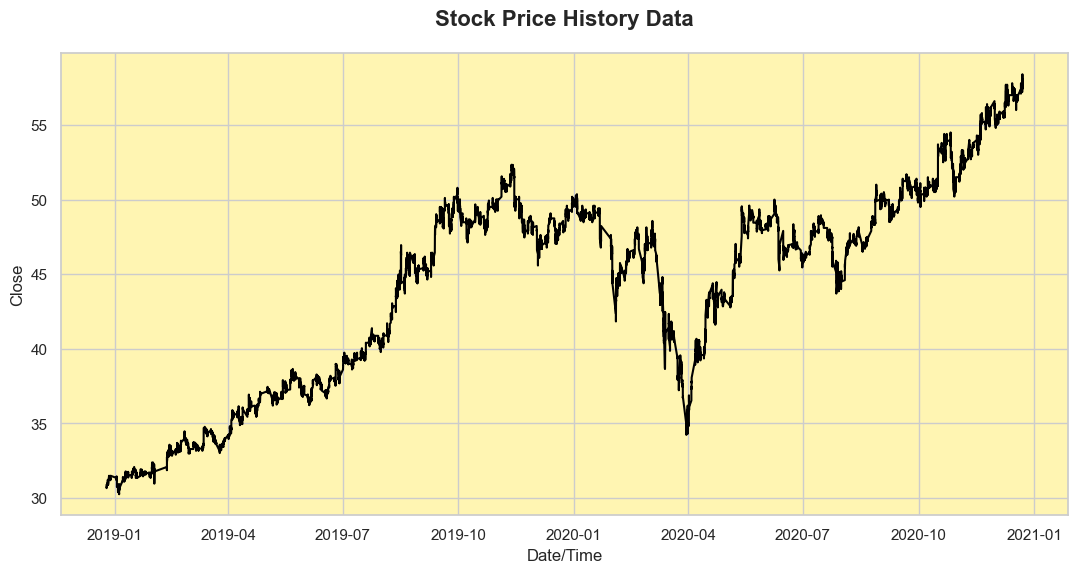

In [62]:
sns.set(style="whitegrid")

# Create the figure and plot the line
plt.figure(figsize=(13, 6))
sns.lineplot(x='Date/Time', y='Close', data=df, color='black')

# Set titles and labels
plt.title("Stock Price History Data", fontsize=16, weight='bold', pad=20)
plt.xlabel("Date/Time", fontsize=12)
plt.ylabel("Close", fontsize=12)

# Customize background color (close to Plotly's 'rgba(255,223,0,0.8)')
plt.gca().set_facecolor((1, 0.87, 0, 0.3))  # RGB normalized with slight transparency

# Display the plot
plt.show()

# 6. Splitting Data

In [63]:
test_size = df[(df['Date/Time'].dt.year==2020) & (df['Date/Time'].dt.month>=10)].shape[0]
test_size

12555

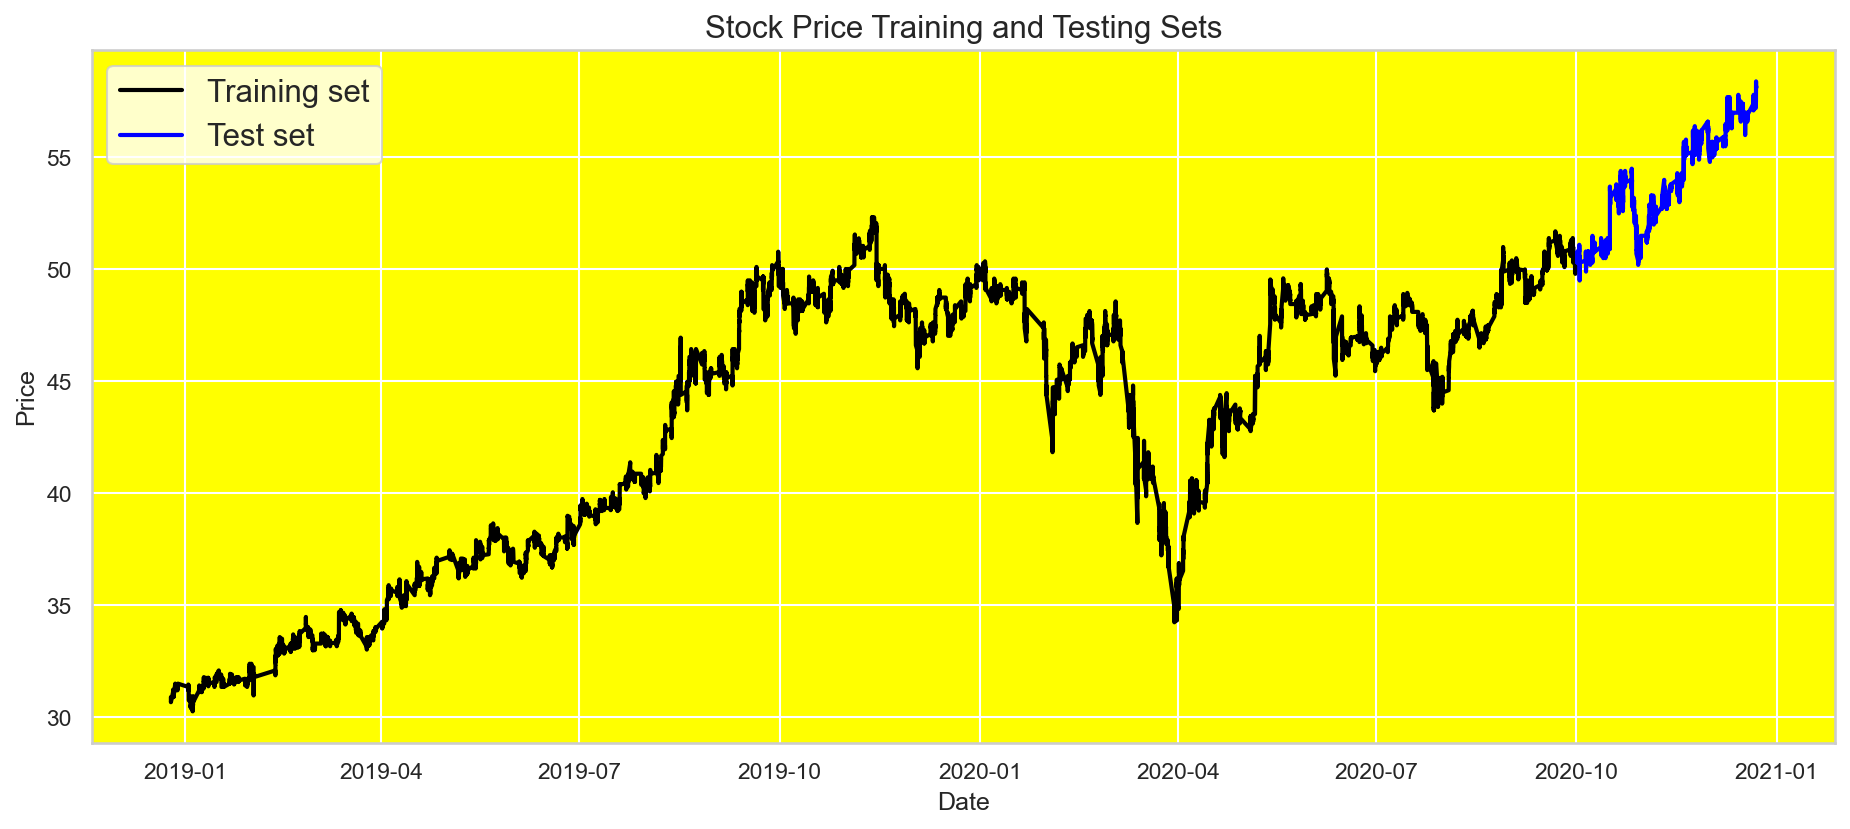

In [64]:
sns.set(style="whitegrid")

# Initialize the figure
plt.figure(figsize=(15, 6), dpi=150)

# Set background color and edge color
plt.gca().set_facecolor('yellow')
plt.rc('axes', edgecolor='white')

# Plot the training and test sets
sns.lineplot(x=df['Date/Time'][:-test_size], y=df['Close'][:-test_size], color='black', linewidth=2, label='Training set')
sns.lineplot(x=df['Date/Time'][-test_size:], y=df['Close'][-test_size:], color='blue', linewidth=2, label='Test set')

# Set titles and labels
plt.title('Stock Price Training and Testing Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Customize legend
plt.legend(loc='upper left', prop={'size': 15})

# Customize grid color
plt.grid(color='white')

# Show plot
plt.show()

# 7. Scaling Data

In [65]:
scaler = MinMaxScaler()
scaler.fit(df['Close'].values.reshape(-1,1))

MinMaxScaler()

# 8. Preparing Data for LSTM and Create Sliding Windows

In [67]:
window_size = 256

## 8.1. Training Set

In [68]:
train_data = df['Close'][:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [69]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

## 8.2. Testing set

In [70]:
test_data = df['Close'][-test_size-window_size:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [71]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

## 8.3. Converting to ndarray

In [72]:
X_train = np.reshape(np.array(X_train), (len(X_train), -1, 1))
X_test = np.reshape(np.array(X_test), (len(X_test), -1, 1))
y_train = np.reshape(np.array(y_train), (-1, 1))
y_test = np.reshape(np.array(y_test), (-1, 1))

print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (84595, 256, 1)
y_train Shape:  (84595, 1)
X_test Shape:   (12555, 256, 1)
y_test Shape:   (12555, 1)


# 9. Defining LSTM

In [83]:
def define_model(hidden_layer = 64, dropout = 0.2, dense_units =32):
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = hidden_layer, return_sequences=True)(input1)  
    x = Dropout(dropout)(x)
    x = LSTM(units = hidden_layer, return_sequences=True)(x)
    x = Dropout(dropout)(x)
    x = LSTM(units = hidden_layer)(x)
    x = Dropout(dropout)(x)
    x = Dense(dense_units, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [84]:
model = define_model(hidden_layer=128, dropout=0.3, dense_units=64)
early_stopping = EarlyStopping(
    monitor='val_loss',  # Dừng khi 'val_loss' không còn cải thiện
    patience=4,         # Số epoch đợi trước khi dừng, nếu không có cải thiện
    restore_best_weights=True  # Khôi phục trọng số tốt nhất
)

history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.1, verbose=1, callbacks=[early_stopping])
model.save('FPT_model_final.h5')

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 256, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 256, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,049 (1.29 MB)

 Trainable params: 338,049 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
595/595 ━━━━━━━━━━━━━━━━━━━━ 418s 700ms/step - loss: 0.0078 - val_loss: 0.0023
Epoch 2/15
595/595 ━━━━━━━━━━━━━━━━━━━━ 443s 744ms/step - loss: 5.0072e-04 - val_loss: 1.1897e-04
Epoch 3/15
595/595 ━━━━━━━━━━━━━━━━━━━━ 446s 749ms/step - loss: 2.3041e-04 - val_loss: 6.6953e-05
Epoch 4/15
595/595 ━━━━━━━━━━━━━━━━━━━━ 498s 836ms/step - loss: 1.8942e-04 - val_loss: 7.8020e-05
Epoch 5/15
595/595 ━━━━━━━━━━━━━━━━━━━━ 454s 763ms/step - loss: 1.7584e-04 - val_loss: 1.3938e-04
Epoch 6/15
595/595 ━━━━━━━━━━━━━━━━━━━━ 453s 761ms/step - loss: 1.6319e-04 - val_loss: 3.0357e-05
Epoch 7/15
595/595 ━━━━━━━━━━━━━━━━━━━━ 454s 763ms/step - loss: 1.3340e-04 - val_loss: 1.8864e-05
Epoch 8/15
595/595 ━━━━━━━━━━━━━━━━━━━━ 454s 762ms/step - loss: 1.1887e-04 - val_loss: 1.2318e-04
Epoch 9/15
595/595 ━━━━━━━━━━━━━━━━━━━━ 455s 765ms/step - loss: 1.0756e-04 - val_loss: 3.9605e-05
Epoch 10/15
595/595 ━━━━━━━━━━━━━━━━━━━━ 454s 763ms/step - loss: 9.8905e-05 - val_loss: 2.2774e-05
Epoch 11/15
595/595 ━━━━━━━

# 10. Evaluation

In [85]:
model_fpt = load_model('FPT_model_final.h5')
loss = model_fpt.evaluate(X_test, y_test)
print('Test Loss: ', loss)

y_pred = model_fpt.predict(X_test)

r2 = r2_score(y_test, y_pred)
print('Test R-Square: ', r2)

393/393 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - loss: 5.1941e-05
Test Loss:  6.22457591816783e-05
393/393 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step
Test R-Square:  0.990443789637606


# 11. Visualizing Result

In [86]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

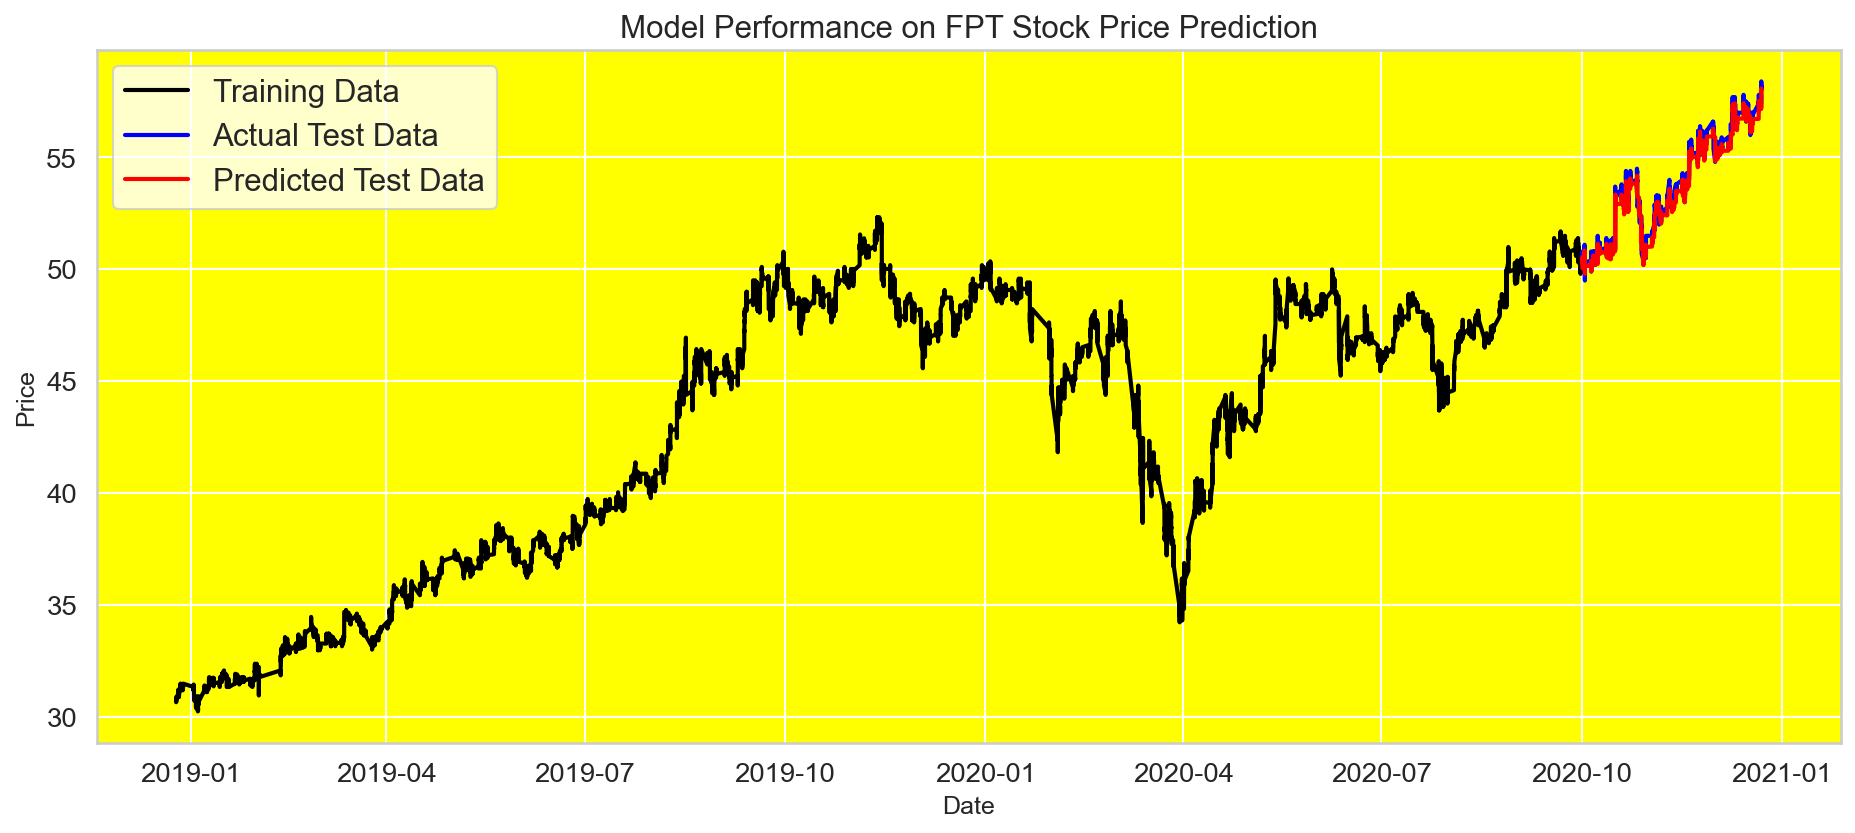

In [89]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Tạo biểu đồ
plt.figure(figsize=(15, 6), dpi=150)
plt.plot(df['Date/Time'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2, label='Training Data')
plt.plot(df['Date/Time'].iloc[-test_size:], y_test_true, color='blue', lw=2, label='Actual Test Data')
plt.plot(df['Date/Time'].iloc[-test_size:], y_test_pred, color='red', lw=2, label='Predicted Test Data')

# Cấu hình chi tiết biểu đồ
plt.gca().set_facecolor('yellow')
plt.rc('axes', edgecolor='white')


plt.title('Model Performance on FPT Stock Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left', prop={'size': 15})
plt.grid(color='white')

# Hiển thị biểu đồ
plt.show()